In [ ]:
# Install libraries
!pip install yfinance prophet pyspark

In [ ]:
# Data processing
import pandas as pd
import numpy as np

# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Multi-processing
from multiprocessing import Pool, cpu_count

# Spark
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType

# Process bar
from tqdm import tqdm

# Tracking time
from time import time

In [ ]:
# Data start date
start_date = '2020-01-02'

# Data end date
end_date = '2024-01-01'
# yfinance excludes the end date, so we need to add one day to the last day of data

In [ ]:
# Download data
ticker_list = ['TSLA', 'GOOG', 'ORCL', 'MSFT', 'AMZN']

data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]

# Drop the top level column name
data.columns = data.columns.droplevel()

# Take a look at the data
data.head()

/tmp/ipython-input-1002157719.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  5 of 5 completed


Ticker,AMZN,GOOG,MSFT,ORCL,TSLA
Date,,,,,
2020-01-02,94.900497,67.964500,152.791153,49.537434,28.684000
2020-01-03,93.748497,67.630989,150.888641,49.362968,29.534000
2020-01-06,95.143997,69.298584,151.278625,49.620068,30.102667
2020-01-07,95.343002,69.255333,149.899307,49.730259,31.270666
2020-01-08,94.598503,69.801102,152.286957,49.923935,32.809334


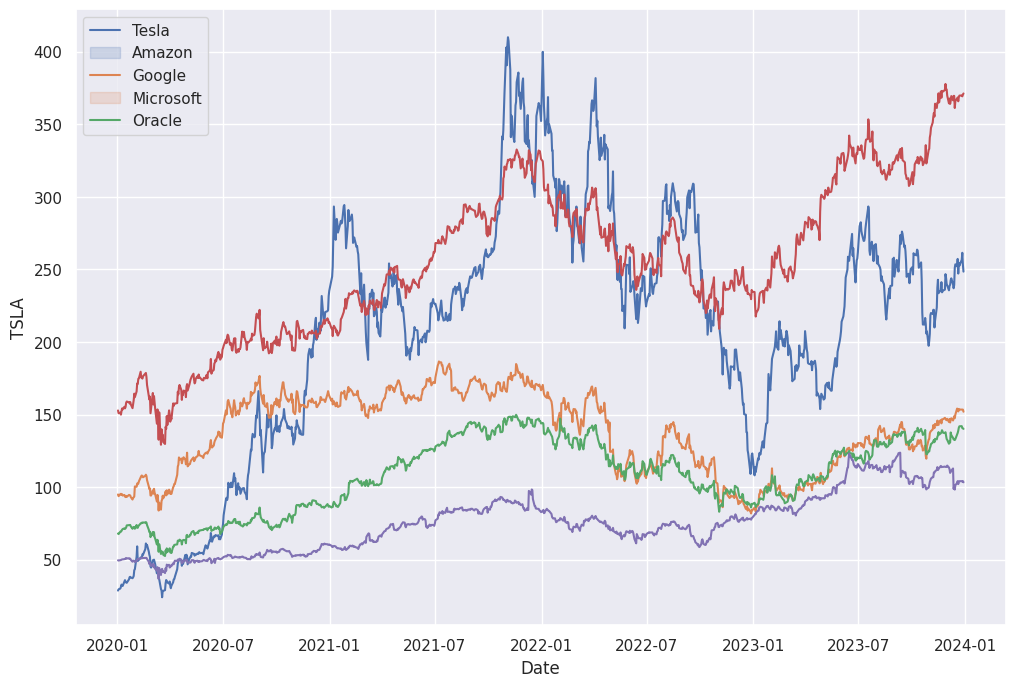

In [ ]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data.index, y=data['TSLA'])
sns.lineplot(x=data.index, y=data['AMZN'])
sns.lineplot(x=data.index, y=data['GOOG'])
sns.lineplot(x=data.index, y=data['MSFT'])
sns.lineplot(x=data.index, y=data['ORCL'])
plt.legend(labels = ['Tesla', 'Amazon', 'Google', 'Microsoft', 'Oracle'])

In [ ]:
# Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMZN    1006 non-null   float64
 1   GOOG    1006 non-null   float64
 2   MSFT    1006 non-null   float64
 3   ORCL    1006 non-null   float64
 4   TSLA    1006 non-null   float64
dtypes: float64(5)
memory usage: 47.2 KB


In [ ]:
# Release Date from the index
data = data.reset_index()

# Change data from the wide format to the long format
df = pd.melt(data, id_vars='Date', value_vars=['AMZN', 'TSLA', 'GOOG', 'MSFT', 'ORCL'])

df.columns = ['ds', 'ticker', 'y']
df.tail(10)
#df.ticker.value_counts()

,ds,ticker,y
5020,2023-12-15,ORCL,101.241913
5021,2023-12-18,ORCL,102.888123
5022,2023-12-19,ORCL,104.112976
5023,2023-12-20,ORCL,102.055214
5024,2023-12-21,ORCL,103.730843
5025,2023-12-22,ORCL,104.063980
5026,2023-12-26,ORCL,104.054199
5027,2023-12-27,ORCL,103.809227
5028,2023-12-28,ORCL,104.112976
5029,2023-12-29,ORCL,103.309479


In [ ]:
# Check the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5030 entries, 0 to 5029
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      5030 non-null   datetime64[ns]
 1   ticker  5030 non-null   object        
 2   y       5030 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 118.0+ KB


In [ ]:
# Group the data by ticker
groups_by_ticker = df.groupby('ticker')
# Check the groups in the dataframe
groups_by_ticker.groups.keys()

dict_keys(['AMZN', 'GOOG', 'MSFT', 'ORCL', 'TSLA'])

In [ ]:
def train_and_forecast(group):
  # Initiate the model
  m = Prophet()

  # Fit the model
  m.fit(group)

  # Make predictions
  future = m.make_future_dataframe(periods=15)
  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['ticker'] = group['ticker'].iloc[0]

  # Return the forecasted results
  return forecast[['ds', 'ticker', 'yhat', 'yhat_upper', 'yhat_lower']]

In [ ]:
# Import SparkSession
from pyspark.sql import SparkSession

# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Check Spark Session Information
spark

In [ ]:
# Convert the pandas dataframe into a spark dataframe
sdf = spark.createDataFrame(df)

# Define the restult schema
result_schema =StructType([
  StructField('ds',DateType()),
  StructField('ticker',StringType()),
  StructField('yhat',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('yhat_lower',FloatType())
  ])

# Start time
start_time = time()

# Train and forecast by ticker
spark_forecast = sdf.groupBy('ticker').applyInPandas(train_and_forecast, schema=result_schema)

# Take a look at the results
spark_forecast.show(5)

# Processing time
print('The time used for the Spark forecast is ', time()-start_time)

+----------+------+----------+----------+----------+
|        ds|ticker|      yhat|yhat_upper|yhat_lower|
+----------+------+----------+----------+----------+
|2020-01-02|  AMZN| 76.426735| 88.328804| 63.965107|
|2020-01-03|  AMZN|-38.185074| -26.66212|-50.717777|
|2020-01-06|  AMZN|-13.445087|-0.8788757|-25.885458|
|2020-01-07|  AMZN|  142.7073| 154.60435| 130.52464|
|2020-01-08|  AMZN|101.996376| 113.68846| 89.688034|
+----------+------+----------+----------+----------+
only showing top 5 rows

The time used for the Spark forecast is  16.660791873931885


In [ ]:
# when we increase the year gap that is end date the forecasting time reduces
# and even if we increase the time period to forecast/predict it gives almost same result